##Exploring S_corr
###Written by Sergio Daniel Hernandez Charpak
####21/06/2016

<p>Notebook for the simple implementation of the Zackay, Ofek and Gal-Yam image substraction method and some test with the implementation.</p>

####References
B. Zackay, E. O. Ofek, and A. Gal-Yam.  Proper image subtraction - optimal transient detection, photometry and hypothesis testing.ArXiv e-prints,January 2016. http://arxiv.org/abs/1601.02655 

####Imports

In [1]:
%pylab inline
#For the linear fit
from sklearn import linear_model
#Open CV used to manage some images
import cv2
#Python functions
from scipy.stats import norm
from math import exp
from matplotlib import pyplot as plt
#Scikit-image for image procesing
from skimage import measure
#To calculate the gradient
from scipy.ndimage import sobel
from scipy.ndimage import prewitt
#To read fits format images
from astropy.io import fits
#Pickle and PIL used to manage images
import pickle
from PIL import Image
#convolution adapted to astronomy in the astropy library
from astropy.convolution import convolve, convolve_fft

Populating the interactive namespace from numpy and matplotlib


###Functions

<p>First we need the functions to form the convolution matrix from a gaussian. </p>

In [2]:
# Auxiliary functions to calculate PSFs
def gaussian(x, mu, sigma):
    return exp( -(((x-mu)/(sigma))**2)/2.0 )

def get_convolution_matrix(kernel_radius, sigma):
    # compute the kernel elements
    hkernel = [gaussian(x, kernel_radius, sigma) for x in range(2*kernel_radius+1)]
    vkernel = [x for x in hkernel]
    kernel2d = [[xh*xv for xh in hkernel] for xv in vkernel]
   
    # normalize the kernel elements
    kernelsum = sum([sum(row) for row in kernel2d])
    kernel2d = [[x/kernelsum for x in row] for row in kernel2d]
    
    return array(kernel2d)

We need the correct way to form a PSF from a given image.

In [3]:
def get_correct_PSF_representation(PSF, image):
    size_e = len(image) - len(PSF)
    PSF_e = np.pad(PSF, ((size_e/2,0),(size_e/2,0)), mode='constant')
    PSF_e = np.pad(PSF_e, ((0,size_e/2),(0,size_e/2)), mode='constant')
    PSF_e = fft.fftshift(PSF_e)
    return PSF_e

Gradient Calculation of an image in an axis (x or y, in this case 0 or 1)

In [4]:
def calculate_gradient(image, axis):
    #return sobel(image, axis=axis, mode='constant')
    #return np.gradient(image)[axis]
    return prewitt(image.copy(), axis=axis, mode='constant')

###Coadition Image R

<p>The equation 22 to 24 descibe how to construct $R$, the coadition image and its PSF</p>
<p>Equation 22</p>
$$\hat{R} = \frac{\sum_j \frac{F_j}{\sigma_j^2} \bar{\hat{P_j}} \hat{R_j} }{\sqrt{ \sum_j \frac{F_j^2}{\sigma_j^2} |\hat{P_j}|^2 }}$$
<p>Equation 23</p>
$$\hat{P_R} = \frac{\sqrt{ \sum_j \frac{F_j^2}{\sigma_j^2} |\hat{P_j}|^2 }}{F_r} $$
<p>Equation 24</p>
$$F_r =  \sqrt{ \sum_j \frac{F_j^2}{\sigma_j^2}  } $$

In [5]:
#Functions to calculate the coadition Reference Image
#@param in arrays, the images, their PSFs, their sigmas and their Fs
#@returns R_r, the coadition image, P_r its PSF normalized by F_r and F_r
def construct_coadition_image(array_images, array_PSF, array_sigmas, array_F):
    F_r = 0
    R_fourier = np.zeros(array_images[0].shape)
    P_r_fourier = np.zeros(array_images[0].shape)
    for i in range(len(aray_images)):
        #Get the values and fourier transform them
        R_j_fourier = fft.fft2(aray_images[i])
        P_j_fourier = fft.fft2(array_PSF[i])
        F_j = array_F[i]
        sigma_j = array_sigmas[i]
        #The different sum terms
        F_r += (F_j**2)/(sigma_j**2)
        P_r_fourier += ((F_j**2)/(sigma_j**2)) * P_j_fourier * np.conjugate(P_j_fourier)
        R_fourier += ((F_j**2)/(sigma_j**2)) * np.conjugate(P_j_fourier) * R_j_fourier
    #Finished the sums
    F_r = np.sqrt(F_r)
    R_fourier = R_fourier / np.sqrt(P_r_fourier)
    P_r_fourier = np.sqrt(P_r_fourier) / F_r
    return R_fourier, P_r_fourier, F_r

###Finding Beta

<p>We only care about the flux zero points ratio.</p> 
<p>We form $\beta \equiv \frac{F_n}{F_r}$ </p>
<p>We follow the indications from the article</p>
<p><i>Solve Equation 39 for the best-fit value of β and optionally γ, ∆x, and ∆y (need to use Eqs. 37 and 38). Since this Equation is non-linear in β use iterations. Set β = 1 in the first iteration, update the value of β and continue until convergence. </i></p>

Equations 37 and 38 correspond to the two part of $\hat{D}$ the fourier transform of the difference image.

<p>Equation 37</p>
$$\hat{D_n}(\beta) = \frac{\hat{P_r} \hat{N}}{\sqrt{\sigma^2_n |\hat{P_r}|^2 + \beta^2 \sigma^2_r |\hat{P_n}|^2}}  $$

<p>Equation 38</p>
$$\hat{D_r}(\beta) = \frac{\hat{P_n} \hat{R}}{\sqrt{\sigma^2_n |\hat{P_r}|^2 + \beta^2 \sigma^2_r |\hat{P_n}|^2}}  $$

<p>We are looking to fit the equation 39</p>
$$D_n(\beta) = \beta D_r(\beta) + \gamma'$$

In [6]:
# Auxiliary functions to calculate beta
def linear_fit(D_r, D_n):
    D_r_elements = D_r.flatten().reshape(-1, 1) 
    D_n_elements = D_n.flatten().reshape(-1, 1) 
    lr_model = linear_model.LinearRegression().fit(D_r_elements, D_n_elements)
    slope = lr_model.coef_[0]
    intercept = lr_model.intercept_
    return slope, intercept

def get_beta(sigma_r, sigma_n, fourier_PSF_r, fourier_PSF_n, fourier_R, fourier_N):
    max_iter_beta = 10000 # maximum number of iterations for the fit
    beta_epsilon = 0.001 # minimum distance for convergence of the fit
    epsilon = 0.001 # avoids division by zero
    beta = 1
    gamma_prime = 0

    beta_converges = False
    num_iter = 0

    while not beta_converges and num_iter < max_iter_beta:
        num_iter = num_iter + 1
        denom = (beta**2)*(sigma_r**2)*(fourier_PSF_n*conjugate(fourier_PSF_n)) + (sigma_n**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
        fourier_D_n = (fourier_PSF_r*fourier_N)/sqrt(denom)
        fourier_D_r = (fourier_PSF_n*fourier_R)/sqrt(denom)
    
        D_n = ifft2(fourier_D_n)
        D_r = ifft2(fourier_D_r)
    
        # Here, they select pixels which are one (really three) sigma above the image noise
        # We don't do that
    
        prev_beta = beta
    
        # The fit we are using ignores imaginary parts, so we fit the squares instead 
        beta, gamma_prime = linear_fit(real(D_r*conjugate(D_r)), real(D_n*conjugate(D_n)))
        if abs(beta - prev_beta) < beta_epsilon:
            beta_converges = True
    return beta

###Finding S and D without corrections

<p>The following implementation of S, the statistical to detect transient candidates, is the simpliest possible one.</p>
<p>It corresponds to:</p>
$$ S = \frac{F_n F^2_r \bar{\hat{P_n}} \hat{P_r}^2 \hat{N} - F_r F^2_n \bar{\hat{P_r}} \hat{P_n}^2 \hat{R} }{\sigma^2_r F^2_n \hat{P_n}^2 +\sigma^2_n F^2_r \hat{P_r}^2 + \epsilon} $$

In [7]:
# Auxiliary functions to calculate S
def get_S_simple(sigma_r, sigma_n, PSF_r, PSF_n, R, N):
    epsilon = 0.001 # avoids division by zero
    fourier_R = fft.fft2(R)
    fourier_N = fft.fft2(N)
    fourier_PSF_r = fft.fft2(PSF_r)
    fourier_PSF_n = fft.fft2(PSF_n)
    F_r = 1
    F_n = get_beta(sigma_r, sigma_n, fourier_PSF_r, fourier_PSF_n, fourier_R, fourier_N)
    denom =(sigma_r**2)*(F_n**2)*(fourier_PSF_n*conjugate(fourier_PSF_n))    
    denom = denom + (sigma_n**2)*(F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
    fourier_S = (F_n)*(F_r**2)*conjugate(fourier_PSF_n)*(fourier_PSF_r*conjugate(fourier_PSF_r))*fourier_N
    fourier_S = fourier_S - (F_r)*(F_n**2)*conjugate(fourier_PSF_r)*(fourier_PSF_n*conjugate(fourier_PSF_n))*fourier_R
    fourier_S = fourier_S/denom
    S = ifft2(fourier_S)
    return real(S)

In [8]:
# Auxiliary functions to calculate D
def get_D(sigma_r, sigma_n, PSF_r, PSF_n, R, N):
    epsilon = 0.001 # avoids division by zero
    fourier_R = fft.fft2(R)
    fourier_N = fft.fft2(N)
    fourier_PSF_r = fft.fft2(PSF_r)
    fourier_PSF_n = fft.fft2(PSF_n)
    F_r = 1
    F_n = get_beta(sigma_r, sigma_n, fourier_PSF_r, fourier_PSF_n, fourier_R, fourier_N)
    denom =(sigma_r**2)*(F_n**2)*(fourier_PSF_n*conjugate(fourier_PSF_n))    
    denom = denom + (sigma_n**2)*(F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
    denom = sqrt(denom)
    fourier_D = (F_r)*fourier_PSF_r*fourier_N
    fourier_D = fourier_D - (F_n)*fourier_PSF_n*fourier_R
    fourier_D = fourier_D/denom
    D = ifft2(fourier_D)
    return real(D)

###Finding S_corr 

<p> We find S following the next level complexity presented in the paper.</p>
<p> We would like to include the proper coaddition image $\sum_j R_j$</p>
<p> We include the Source and Astrometric noises corrections </p>

####Inputs
<ul>
<li>$N$, background substracted New Image (with possible transients)</li>
<li>$R_j$, background substracted member of the Reference Image</li>
<li>$N_b$, New Image with background</li>
<li>$R_{j_b}$, member of the Reference image with background</li>
<li>$\sigma_n$, standard deviation of $N$</li>
<li>$\sigma_{r_j}$, standard deviation of $R_j$</li>
<li>$r_n$, read noise from $N$</li>
<li>$r_{r_j}$, read noise from $R_j$</li>
<li>$\sigma_x$, rms  (in  pixels)  of  the  astrometric  registration solution  in  the  X-axis. This  is  either  a  scalar  or  a matrix</li>
<li>$\sigma_y$, rms  (in  pixels)  of  the  astrometric  registration solution  in  the  Y-axis. This  is  either  a  scalar  or  a matrix </li>
</ul>

<p> $$ S = S_n - \sum_j S_{R_j} $$ </p>
<p> With:</p>
$$ \hat{S_n} = \frac{ \frac{F_n \bar{\hat{P_n}} }{\sigma^2_n} \left( \sum_j \frac{F_j^2 |\hat{P_j}|^2}{\sigma^2_j} \right) }{ \frac{F_n |\hat{P_n}|^2 }{\sigma^2_n} + \left( \sum_j \frac{F_j^2 |\hat{P_j}|^2}{\sigma^2_j} \right)  } \hat{N} = \hat{k_n} \hat{N} $$
<p> and: </p>
$$ \hat{S_{R_j}} = \frac{ \frac{F_n |\hat{P_n}|^2 }{\sigma^2_n} \left( \frac{F_j^2 \bar{\hat{P_j}}}{\sigma^2_j} \right) }{ \frac{F_n |\hat{P_n}|^2 }{\sigma^2_n} + \left( \sum_j \frac{F_j^2 |\hat{P_j}|^2}{\sigma^2_j} \right)  } \hat{R_j} = \hat{k_j} \hat{R_j} $$
<p> We corect it for the different type of noise </p>
$$ S_{corr} = \frac{S_n - \sum_j S_{R_j} }{\sqrt{ V(S_n) + \sum_j V(S_{R_j}) + V_{ast}(S_n) +\sum_j V_{ast}(S_{R_j}) }} $$
<p>with:</p>
<p> $V(S_n) = V(\epsilon_n) \otimes (k_n^2)$,</p>
<p> $V(S_{R_j}) = V(\epsilon_j) \otimes (k_j^2)$,</p>
<p> $V_{ast}(S_n) = \sigma_x^2 ( \frac{d S_n}{dx} )^2 + \sigma_y^2 ( \frac{d S_n}{dy} )^2  $,</p>
<p> $V_{ast}(S_{R_j}) = \sigma_x^2 ( \frac{d S_{R_j}}{dx} )^2 + \sigma_y^2 ( \frac{d S_{R_j}}{dy} )^2 $,</p>
<p>with:</p>
<p> $V(\epsilon_n) = N_b + r_n^2$,</p>
<p> $V(\epsilon_j) = R_b + r_r^2$</p>

#####Note:
<p>The present implementation is binary. It doesn't fully yet use the proper coadition as it was presented previously</p>
<p>This means that the sum terms disapear:</p>

<p> $$ S = S_n - S_{R_j} $$ </p>
<p> With:</p>
$$ \hat{S_n} = \frac{ \frac{F_n \bar{\hat{P_n}} }{\sigma^2_n} \left(  \frac{F_j^2 |\hat{P_j}|^2}{\sigma^2_j} \right) }{ \frac{F_n |\hat{P_n}|^2 }{\sigma^2_n} + \left( \frac{F_j^2 |\hat{P_j}|^2}{\sigma^2_j} \right)  } \hat{N} = \hat{k_n} \hat{N} $$
<p> and: </p>
$$ \hat{S_{R_j}} = \frac{ \frac{F_n |\hat{P_n}|^2 }{\sigma^2_n} \left( \frac{F_j^2 \bar{\hat{P_j}}}{\sigma^2_j} \right) }{ \frac{F_n |\hat{P_n}|^2 }{\sigma^2_n} + \left(  \frac{F_j^2 |\hat{P_j}|^2}{\sigma^2_j} \right)  } \hat{R_j} = \hat{k_j} \hat{R_j} $$
<p> We corect it for the different type of noise </p>
$$ S_{corr} = \frac{S_n -  S_{R_j} }{\sqrt{ V(S_n) +  V(S_{R_j}) + V_{ast}(S_n) + V_{ast}(S_{R_j})  }} $$
<p>with:</p>
<p> $V(S_n) = V(\epsilon_n) \otimes (k_n^2)$,</p>
<p> $V(S_{R_j}) = V(\epsilon_j) \otimes (k_j^2)$,</p>
<p> $V_{ast}(S_n) = \sigma_x^2 ( \frac{d S_n}{dx} )^2 + \sigma_y^2 ( \frac{d S_n}{dy} )^2  $,</p>
<p> $V_{ast}(S_{R_j}) = \sigma_x^2 ( \frac{d S_{R_j}}{dx} )^2 + \sigma_y^2 ( \frac{d S_{R_j}}{dy} )^2 $,</p>
<p>with:</p>
<p> $V(\epsilon_n) = N_b + r_n^2$,</p>
<p> $V(\epsilon_j) = R_b + r_r^2$</p>

In [9]:
# Auxiliary functions to calculate S corr
def get_S_n(sigma_r, sigma_n, PSF_r, PSF_n, R, N):
    epsilon = 0.001 # avoids division by zero
    fourier_R = fft.fft2(R)
    fourier_N = fft.fft2(N)
    fourier_PSF_r = fft.fft2(PSF_r)
    fourier_PSF_n = fft.fft2(PSF_n)
    F_r = 1
    F_n = get_beta(sigma_r, sigma_n, fourier_PSF_r, fourier_PSF_n, fourier_R, fourier_N)
    denom_n =(F_n**2)*(fourier_PSF_n*conjugate(fourier_PSF_n))/(sigma_n**2)
    denom_n = denom_n + (F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r))/(sigma_r**2) + epsilon
    fourier_S_n = ((F_n)*(conjugate(fourier_PSF_n))/(sigma_n**2)) 
    fourier_S_n = fourier_S_n * (F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r))/(sigma_r**2)
    fourier_k_n = fourier_S_n/denom_n
    fourier_S_n = fourier_k_n * fourier_N
    S_n = ifft2(fourier_S_n)
    k_n = ifft2(fourier_k_n)
    return real(S_n), real(k_n)

def get_S_r(sigma_r, sigma_n, PSF_r, PSF_n, R, N):
    epsilon = 0.001 # avoids division by zero
    fourier_R = fft.fft2(R)
    fourier_N = fft.fft2(N)
    fourier_PSF_r = fft.fft2(PSF_r)
    fourier_PSF_n = fft.fft2(PSF_n)
    F_r = 1
    F_n = get_beta(sigma_r, sigma_n, fourier_PSF_r, fourier_PSF_n, fourier_R, fourier_N)
    denom_r =(F_n**2)*(fourier_PSF_n*conjugate(fourier_PSF_n))/(sigma_n**2)
    denom_r = denom_r + (F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r))/(sigma_r**2) + epsilon
    fourier_S_r = ((F_n)*(fourier_PSF_n*conjugate(fourier_PSF_n))/(sigma_n**2)) 
    fourier_S_r = fourier_S_r * (F_r**2)*(conjugate(fourier_PSF_r))/(sigma_r**2)
    fourier_k_r = fourier_S_r/denom_r
    fourier_S_r = fourier_k_r * fourier_R
    S_r = ifft2(fourier_S_r)
    k_r = ifft2(fourier_k_r)
    return real(S_r), real(k_r)

def get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N):
    S_n, k_n = get_S_n(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
    S_r, k_r = get_S_r(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
    S = S_n - S_r
    return S, S_n, S_r, k_n, k_r

def get_S_corr_source(sigma_r, sigma_n, PSF_r, PSF_n, R, N, N_b, R_b, r_n, r_r):
    S, S_n, S_r, k_n, k_r = get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
    V_e_n = N_b + r_n**2
    V_e_r = R_b + r_r**2
    #V_S_n = convolve(V_e_n, k_n**2, boundary='extend')
    #V_S_r = convolve(V_e_r, k_r**2, boundary='extend')
    V_S_n = real(fft.ifft2(fft.fft2(V_e_n)*fft.fft2(k_n**2)))
    V_S_r = real(fft.ifft2(fft.fft2(V_e_r)*fft.fft2(k_r**2)))
    S_corr = S/np.sqrt(V_S_n + V_S_r)
    return real(S_corr)

def get_S_corr_astro(sigma_r, sigma_n, PSF_r, PSF_n, R, N, N_b, R_b, r_n, r_r, sigma_x_n, sigma_y_n, sigma_x_r, sigma_y_r):
    S, S_n, S_r, k_n, k_r = get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
    V_e_n = N_b + r_n**2
    V_e_r = R_b + r_r**2
    #V_S_n = convolve(V_e_n, k_n**2, boundary='extend')
    V_S_n = real(fft.ifft2(fft.fft2(V_e_n)*fft.fft2(k_n**2)))
    #V_S_r = convolve(V_e_r, k_r**2, boundary='extend')
    V_S_r = real(fft.ifft2(fft.fft2(V_e_r)*fft.fft2(k_r**2)))
    d_S_n_d_x = calculate_gradient(S_n, 0)
    d_S_n_d_y = calculate_gradient(S_n, 1)
    d_S_r_d_x = calculate_gradient(S_r, 0)
    d_S_r_d_y = calculate_gradient(S_r, 1)
    V_ast_S_n =  (sigma_x_n**2)*(d_S_n_d_x**2) + (sigma_y_n**2)*(d_S_n_d_y**2)
    V_ast_S_r =  (sigma_x_r**2)*(d_S_r_d_x**2) + (sigma_y_r**2)*(d_S_r_d_y**2)
    S_corr = S/np.sqrt(V_S_n + V_S_r + V_ast_S_n + V_ast_S_r)
    return real(S_corr)

###Finding transient candidates
<p>We find transient candidates, in unites of $\sigma_S$ in the images $S$ or $S_corr$ looking at values over, or under a threshold</p>

In [10]:
# Auxiliary functions to print candidates
def print_candidates(S, num_sigma):
    sigma_S = std(S)
    candidates = np.zeros(shape(S))
    for i in range(len(S)):
        for j in range(len(S)):
            if abs(S[i][j]) < num_sigma*sigma_S:
                candidates[i][j] = 255
    fig = plt.figure(figsize = (8,8))
    plt.imshow(candidates, cmap = 'Greys_r', origin='lower')
    plt.title('Transient Candidates', fontsize=18)
    plt.xlabel("x (pixels) ", fontsize=20)
    plt.ylabel("y (pixels) ", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    candidates = measure.label(candidates)
    for i in range(np.max(candidates)):
        x = str(average(np.where(candidates == (i + 1))[0]))
        y = str(average(np.where(candidates == (i + 1))[1]))
        print("Candidate " + str(i + 1) + ": (" + x + ", " + y + ")")

In [11]:
# Under a threshold
def print_candidates_min(S, num_sigma):
    sigma_S = np.std(S)
    candidates_min = np.zeros(shape(S))
    for i in range(len(S)):
        for j in range(len(S)):
            if abs(S[i][j]) < ( num_sigma*sigma_S):
                candidates_min[i][j] = 255
    
    fig = plt.figure(figsize = (8,8))
    plt.imshow(candidates_min, cmap = 'Greys_r', origin='lower')
    plt.title('Transient Candidates', fontsize=18)
    plt.xlabel("x (pixels) ", fontsize=20)
    plt.ylabel("y (pixels) ", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    candidates_min = measure.label(candidates_min)
    #For the cross on the candidates
    x_max, y_max = shape(S)
    #--------------------------
    for i in range(np.max(candidates_min)):
        y = str(average(np.where(candidates_min == (i + 1))[0]))
        x = str(average(np.where(candidates_min == (i + 1))[1]))
        #cross on the candidate

        axhline(float(y),(float(x)-x_max*0.02)/x_max,(float(x)+x_max*0.02)/x_max,c='c')
        axvline(float(x),(float(y)-y_max*0.02)/y_max,(float(y)+y_max*0.02)/y_max,c='c') 
        text(float(x)+x_max*0.02,float(y)+y_max*0.02,str(i + 1),color='c',fontsize=12)
        #--------------------------
        print("Candidate (minimum analysis) " + str(i + 1) + ": (" + x + ", " + y + ")")

# Over a threshold
def print_candidates_max(S, num_sigma):
    sigma_S = np.std(S)
    candidates_max = np.zeros(shape(S))
    for i in range(len(S)):
        for j in range(len(S)):
            if abs(S[i][j]) > ( num_sigma*sigma_S):
                candidates_max[i][j] = 255
    fig = plt.figure(figsize = (8,8))
    plt.imshow(candidates_max, cmap = 'Greys_r', origin='lower')
    plt.title('Transient Candidates', fontsize=18)
    plt.xlabel("x (pixels) ", fontsize=20)
    plt.ylabel("y (pixels) ", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    candidates_max = measure.label(candidates_max)
    #For the cross on the candidates
    x_max, y_max = shape(S)
    #--------------------------
    for i in range(np.max(candidates_max)):
        y = str(average(np.where(candidates_max == (i + 1))[0]))
        x = str(average(np.where(candidates_max == (i + 1))[1]))
        #cross on the candidate
        axhline(float(y),(float(x)-x_max*0.02)/x_max,(float(x)+x_max*0.02)/x_max,c='c')
        axvline(float(x),(float(y)-y_max*0.02)/y_max,(float(y)+y_max*0.02)/y_max,c='c') 
        text(float(x)+x_max*0.02,float(y)+y_max*0.02,str(i + 1),color='c',fontsize=12)
        #--------------------------
        print("Candidate (maximum analysis) " + str(i + 1) + ": (" + x + ", " + y + ")")

##Testing the method

###Simulated images

####With astrometric and source noises

<p>In the paper it is stated that:</p>
<p>In practice the astrometric registration
noise is the rms of the registration  fitting process</p>
<p> The autors present a better way to treat astrometric noise but they state: </p>
<p>The details of this method will be presented in a future publication</p>

In [12]:
#Astrometric noise
R = fits.getdata('./Images/withNoiseAstrometric/ReferenceImage.fits')
N = fits.getdata('./Images/withNoiseAstrometric/NewImage.fits')

#For testing
R_b = fits.getdata('./Images/withNoiseAstrometric/ReferenceImage_b.fits') 
N_b = fits.getdata('./Images/withNoiseAstrometric/NewImage_b.fits') 

r_n = 0
r_r = 0

#Previous parameters
sigma_r = 31.6240639156
sigma_n = 31.7161483352

#rms of of the registration process, in practice
#Here we simply calculate the std of each axis
sigma_x_n = np.std(N,axis=0)
sigma_y_n = np.std(N,axis=1)
sigma_x_r = np.std(R,axis=0)
sigma_y_r = np.std(R,axis=1)

tile_size = 25
sigma_PSF = 3.
PSF_r = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF), R)
PSF_n = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF), N)


S_corr_astro = get_S_corr_astro(sigma_r, sigma_n, PSF_r, PSF_n, R, N, N_b, R_b, r_n, r_r, sigma_x_n, sigma_y_n, sigma_x_r, sigma_y_r)
S_corr_source = get_S_corr_source(sigma_r, sigma_n, PSF_r, PSF_n, R, N, N_b, R_b, r_n, r_r)

S = get_S_simple(sigma_r, sigma_n, PSF_r, PSF_n, R, N) 
D = get_D(sigma_r, sigma_n, PSF_r, PSF_n, R, N)


<p>It is stated in the paper that $\sigma_{S_{corr}} \approx 1$ </p>
<p>We check</p>

In [13]:
print np.std(S_corr_astro),np.std(S_corr_source), np.std(S)

0.0357678668714 1.09693217446 0.00180905938716


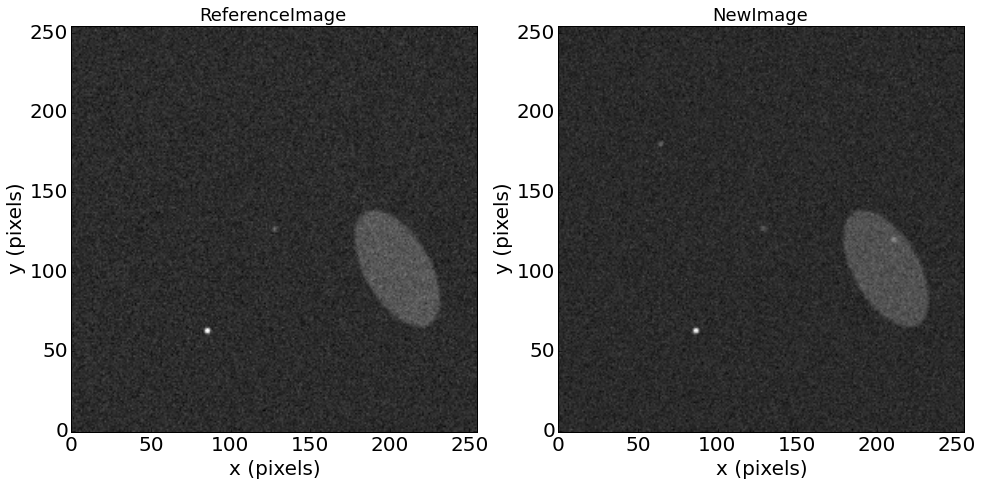

In [14]:
fig = plt.figure(figsize = (16,8))
fig.add_subplot(1, 2, 1)  # this line outputs images side-by-side
plt.imshow(R, cmap = 'gray', origin='lower')
plt.title('ReferenceImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
fig.add_subplot(1, 2, 2)  # this line outputs images side-by-side
plt.imshow(N,  cmap = 'gray', origin='lower')
plt.title('NewImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [15]:
plt.close(fig)

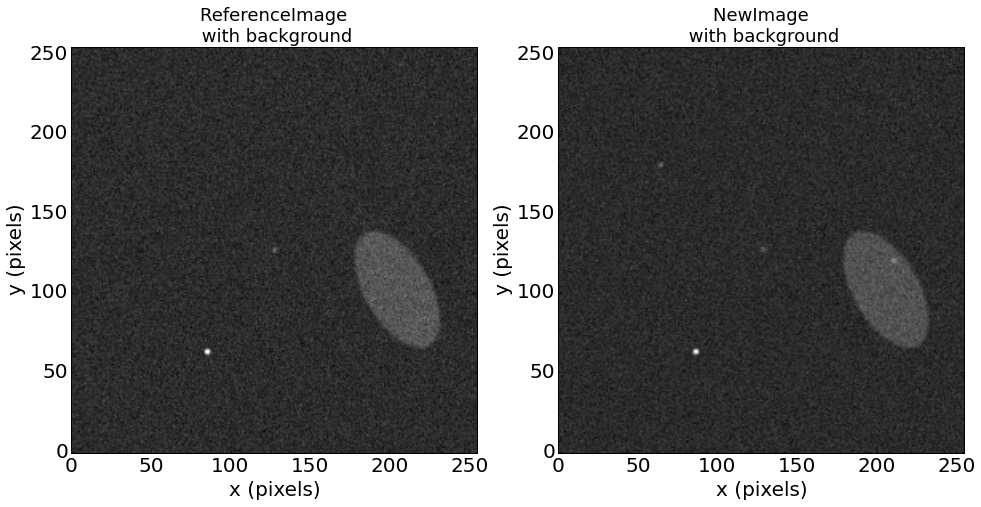

In [16]:
fig = plt.figure(figsize = (16,8))
fig.add_subplot(1, 2, 1)  # this line outputs images side-by-side
plt.imshow(R_b, cmap = 'gray', origin='lower')
plt.title('ReferenceImage \n with background', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
fig.add_subplot(1, 2, 2)  # this line outputs images side-by-side
plt.imshow(N_b,  cmap = 'gray', origin='lower')
plt.title('NewImage \n with background', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [17]:
plt.close(fig)

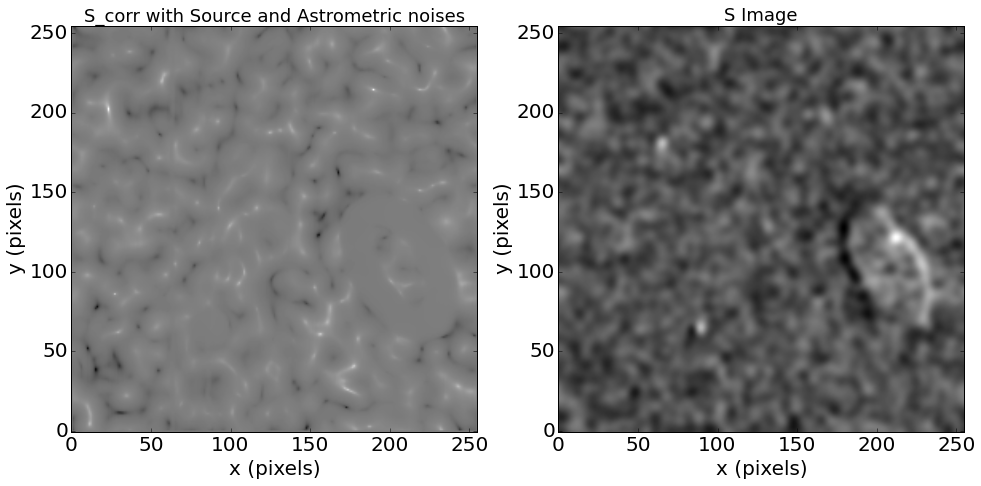

In [18]:
fig = plt.figure(figsize = (16,8))
fig.add_subplot(1, 2, 1)  # this line outputs images side-by-side
plt.imshow(S_corr_astro, cmap = 'gray', origin='lower')
plt.title('S_corr with Source and Astrometric noises', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
fig.add_subplot(1, 2, 2)  # this line outputs images side-by-side
plt.imshow(S, cmap = 'gray', origin='lower')
plt.title('S Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [19]:
plt.close(fig)

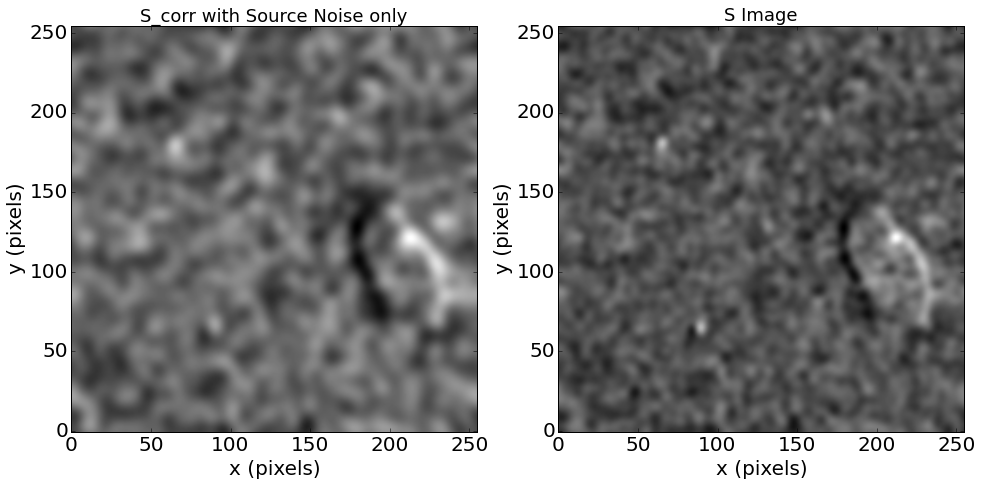

In [20]:
fig = plt.figure(figsize = (16,8))
fig.add_subplot(1, 2, 1)  # this line outputs images side-by-side
plt.imshow(S_corr_source, cmap = 'gray', origin='lower')
plt.title('S_corr with Source Noise only', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
fig.add_subplot(1, 2, 2)  # this line outputs images side-by-side
plt.imshow(S, cmap = 'gray', origin='lower')
plt.title('S Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [21]:
plt.close(fig)

Candidate (minimum analysis) 1: (127.054276113, 127.069922309)


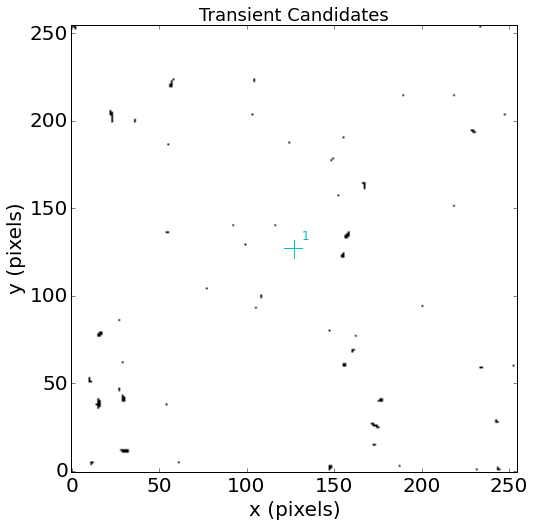

In [22]:
print_candidates_min(S_corr_astro,5)

In [23]:
plt.close(fig)

Candidate (minimum analysis) 1: (126.874772832, 127.012059141)


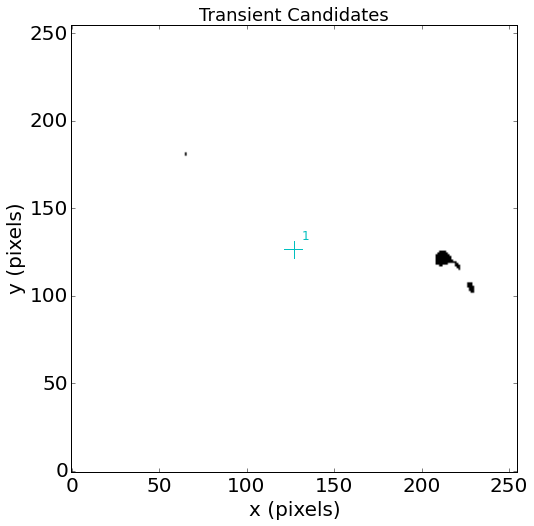

In [24]:
print_candidates_min(S,5)

In [25]:
plt.close(fig)

Candidate (maximum analysis) 1: (147.0, 2.0)
Candidate (maximum analysis) 2: (172.0, 15.0)
Candidate (maximum analysis) 3: (173.0, 26.0)
Candidate (maximum analysis) 4: (15.0, 38.5)
Candidate (maximum analysis) 5: (177.0, 41.0)
Candidate (maximum analysis) 6: (10.0, 52.0)
Candidate (maximum analysis) 7: (156.0, 61.0)
Candidate (maximum analysis) 8: (15.5, 77.5)
Candidate (maximum analysis) 9: (27.0, 86.0)
Candidate (maximum analysis) 10: (154.5, 123.0)
Candidate (maximum analysis) 11: (158.0, 135.0)
Candidate (maximum analysis) 12: (167.0, 162.5)
Candidate (maximum analysis) 13: (23.0, 202.0)
Candidate (maximum analysis) 14: (189.0, 214.0)


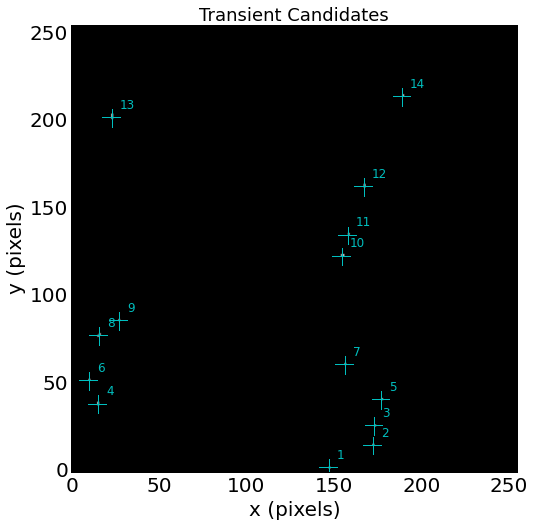

In [26]:
print_candidates_max(S_corr_astro,8)

In [27]:
plt.close(fig)

Candidate (maximum analysis) 1: (227.611111111, 104.666666667)
Candidate (maximum analysis) 2: (212.92, 120.493333333)
Candidate (maximum analysis) 3: (65.0, 180.5)


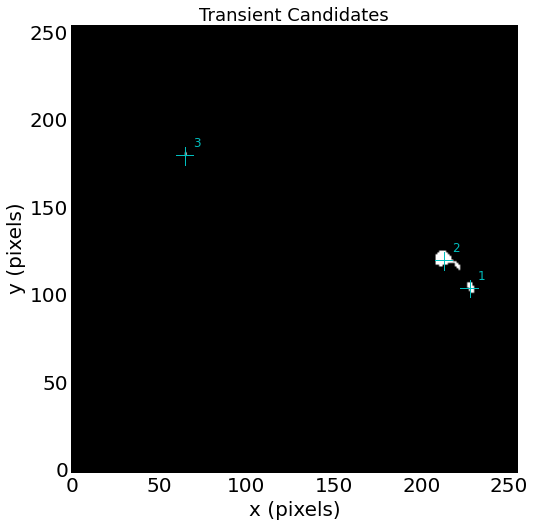

In [28]:
print_candidates_max(S,5)

In [29]:
plt.close(fig)

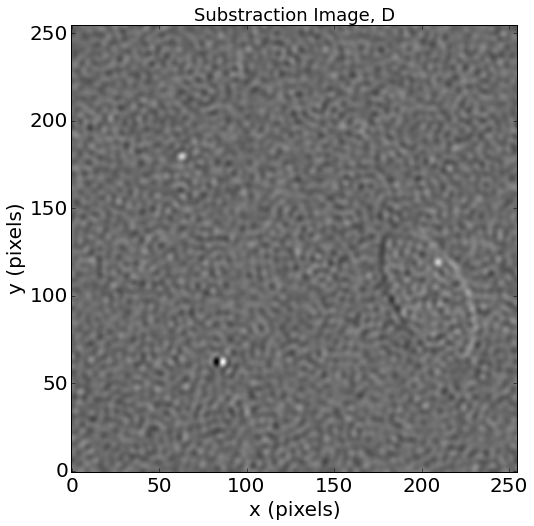

In [30]:
fig = plt.figure(figsize = (8,8))
plt.imshow(D, cmap = 'gray', origin='lower')
plt.title('Substraction Image, D', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [31]:
plt.close(fig)

####With only source noise

In [32]:
#Source Noise
R = fits.getdata('./Images/withNoise/ReferenceImage.fits')
N = fits.getdata('./Images/withNoise/NewImage.fits')

#For testing
R_b = fits.getdata('./Images/withNoise/ReferenceImage_b.fits') 
N_b = fits.getdata('./Images/withNoise/NewImage_b.fits') 

r_n = 0
r_r = 0

#Previous parameters
sigma_r = 40.3336975657
sigma_n = 40.7337479646

tile_size = 25
sigma_PSF = 3.
PSF_r = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF), R)
PSF_n = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF), N)


S_corr = get_S_corr_source(sigma_r, sigma_n, PSF_r, PSF_n, R, N, N_b, R_b, r_n, r_r)
S = get_S_simple(sigma_r, sigma_n, PSF_r, PSF_n, R, N) 
D = get_D(sigma_r, sigma_n, PSF_r, PSF_n, R, N)


In [33]:
print np.std(S_corr), np.std(S)

1.01566323117 0.00104137304893


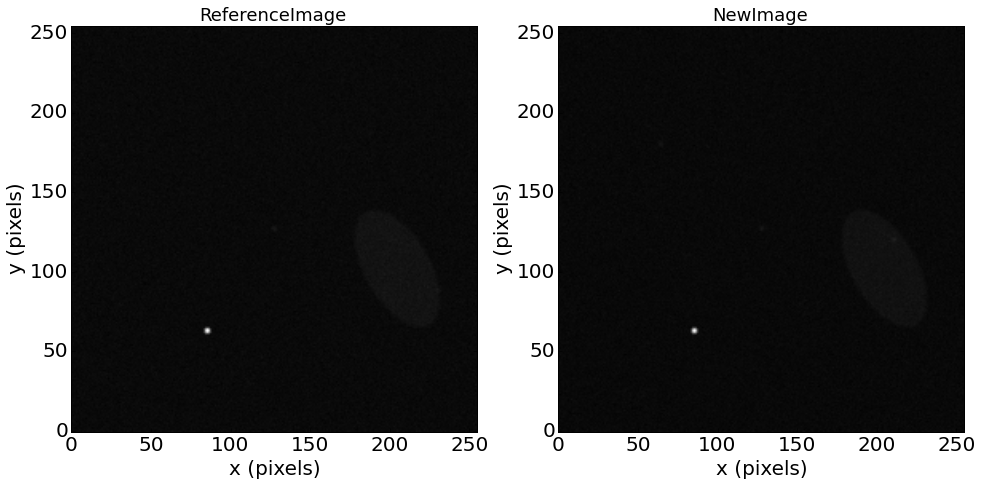

In [34]:
fig = plt.figure(figsize = (16,8))
fig.add_subplot(1, 2, 1)  # this line outputs images side-by-side
plt.imshow(R, cmap = 'gray', origin='lower')
plt.title('ReferenceImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
fig.add_subplot(1, 2, 2)  # this line outputs images side-by-side
plt.imshow(N,  cmap = 'gray', origin='lower')
plt.title('NewImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [35]:
plt.close(fig)

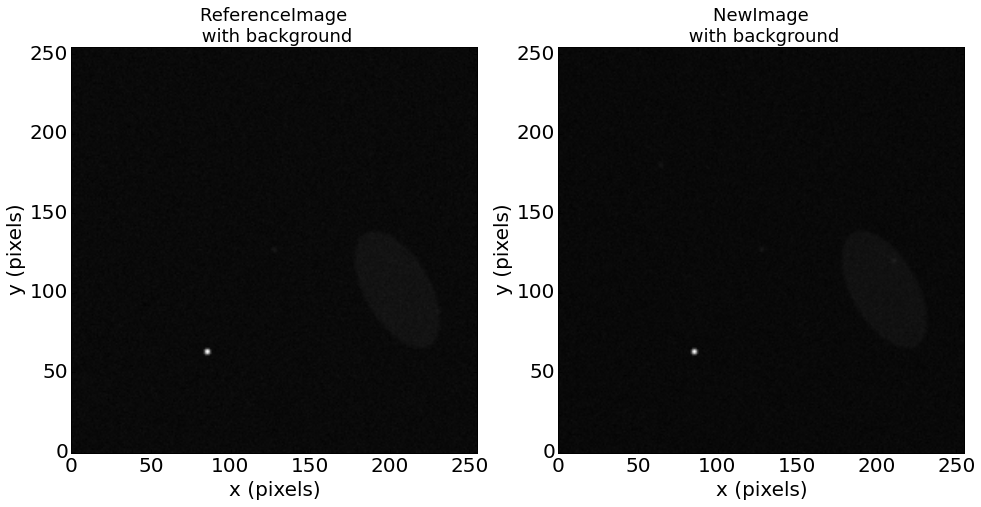

In [36]:
fig = plt.figure(figsize = (16,8))
fig.add_subplot(1, 2, 1)  # this line outputs images side-by-side
plt.imshow(R_b, cmap = 'gray', origin='lower')
plt.title('ReferenceImage \n with background', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
fig.add_subplot(1, 2, 2)  # this line outputs images side-by-side
plt.imshow(N_b,  cmap = 'gray', origin='lower')
plt.title('NewImage \n with background', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [37]:
plt.close(fig)

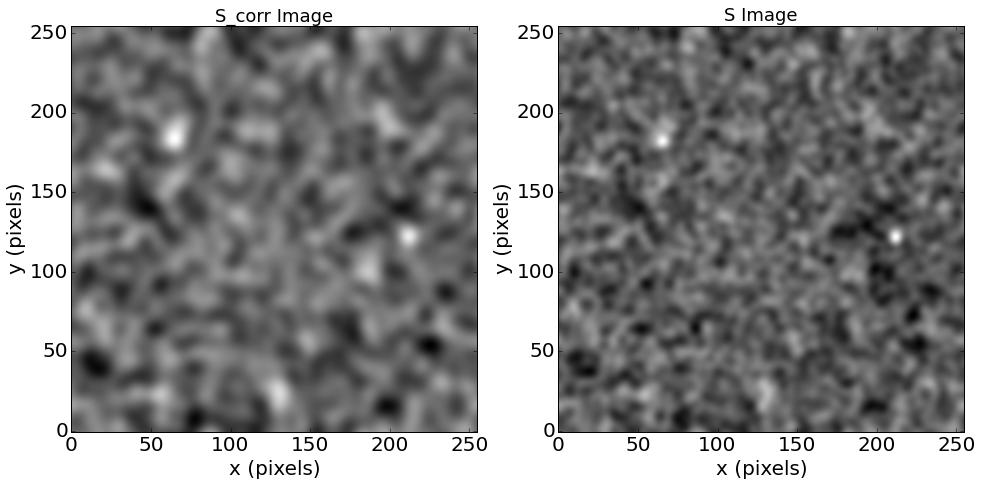

In [38]:
fig = plt.figure(figsize = (16,8))
fig.add_subplot(1, 2, 1)  # this line outputs images side-by-side
plt.imshow(S_corr, cmap = 'gray', origin='lower')
plt.title('S_corr Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
fig.add_subplot(1, 2, 2)  # this line outputs images side-by-side
plt.imshow(S, cmap = 'gray', origin='lower')
plt.title('S Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [39]:
plt.close(fig)

Candidate (minimum analysis) 1: (127.017305829, 126.984278616)


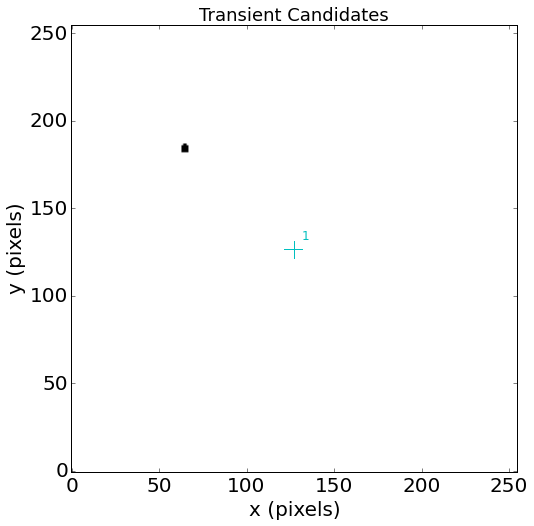

In [40]:
print_candidates_min(S_corr,5)

In [41]:
plt.close(fig)

Candidate (minimum analysis) 1: (127.003185056, 126.983259221)


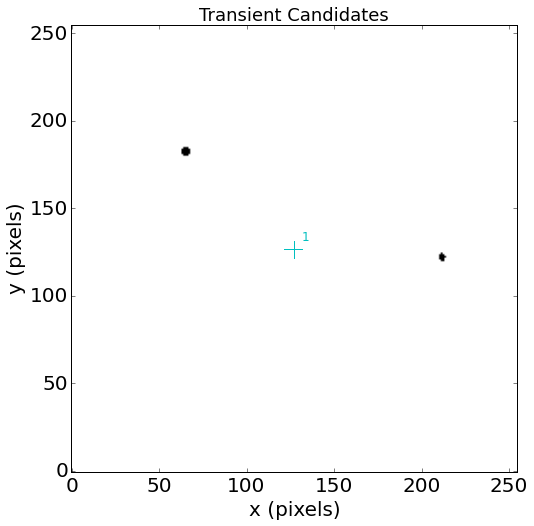

In [42]:
print_candidates_min(S,5)

In [43]:
plt.close(fig)

Candidate (maximum analysis) 1: (64.5, 183.777777778)


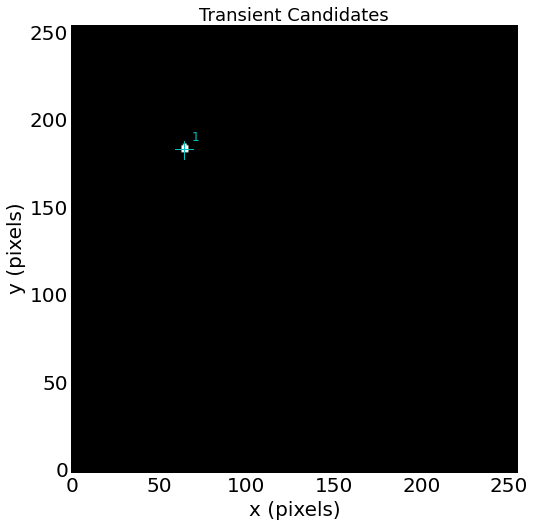

In [44]:
print_candidates_max(S_corr,5)

In [45]:
plt.close(fig)

Candidate (maximum analysis) 1: (211.230769231, 121.846153846)
Candidate (maximum analysis) 2: (65.0, 182.0)


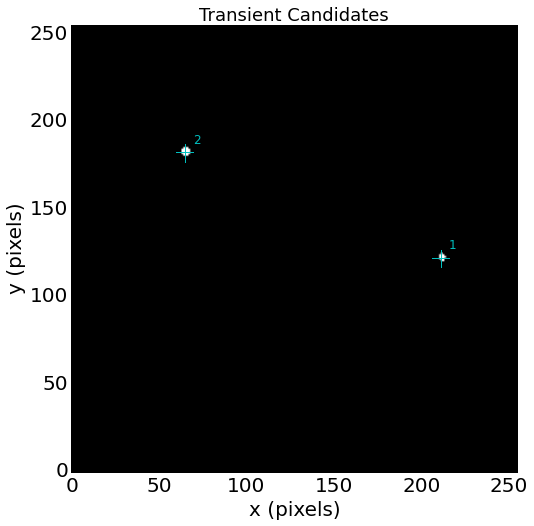

In [46]:
print_candidates_max(S, 5)

In [47]:
plt.close(fig)

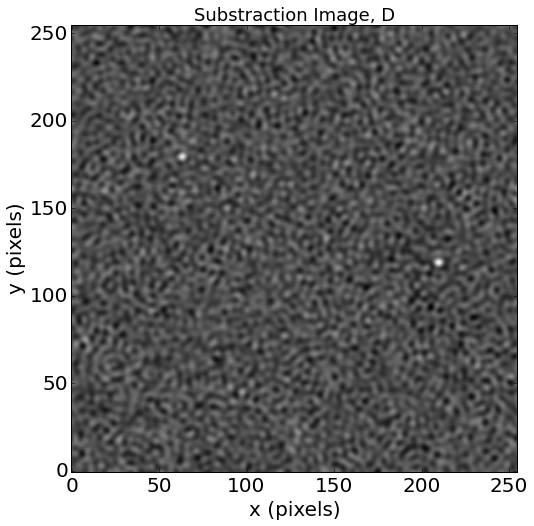

In [48]:
fig = plt.figure(figsize = (8,8))
plt.imshow(D, cmap = 'gray', origin='lower')
plt.title('Substraction Image, D', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [49]:
plt.close(fig)

####With Gausian sources. No source noise

In [50]:
R = cv2.imread('./Images/withGaussianSources/ReferenceImage.jpg', cv2.CV_LOAD_IMAGE_GRAYSCALE) 
N = cv2.imread('./Images/withGaussianSources/NewImage.jpg', cv2.CV_LOAD_IMAGE_GRAYSCALE) 

#For testing
R_b = R
N_b = N

r_n = 0
r_r = 0

#Previous parameters
sigma_r = 50 
sigma_n = 50 

tile_size = 25
sigma_PSF = 3.
PSF_r = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF), R)
PSF_n = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF), N)


S_corr = get_S_corr_source(sigma_r, sigma_n, PSF_r, PSF_n, R, N, N_b, R_b, r_n, r_r)
D = get_D(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
S = get_S_simple(sigma_r, sigma_n, PSF_r, PSF_n, R, N)

In [51]:
print np.std(S_corr)

1.58187184917


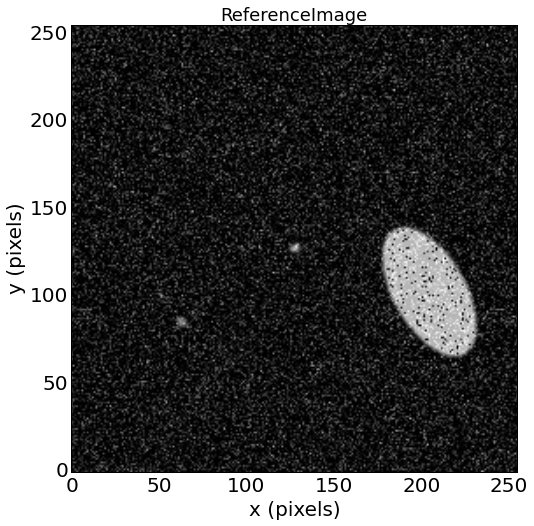

In [52]:
fig = plt.figure(figsize = (8,8))
plt.imshow(Image.fromarray(R), cmap = 'gray', origin='lower')
plt.title('ReferenceImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [53]:
plt.close(fig)

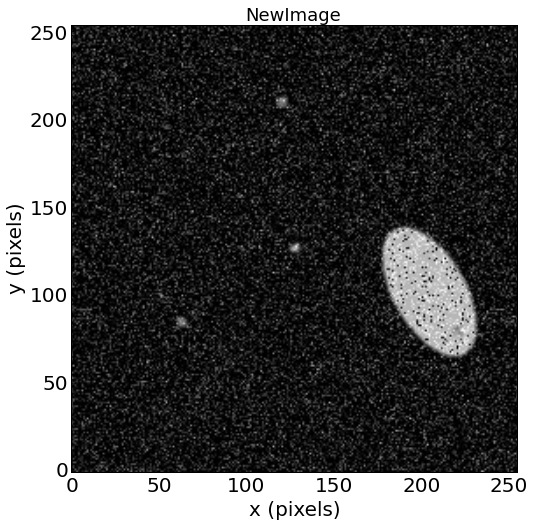

In [54]:
fig = plt.figure(figsize = (8,8))
plt.imshow(Image.fromarray(N), cmap = 'gray', origin='lower')
plt.title('NewImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [55]:
plt.close(fig)

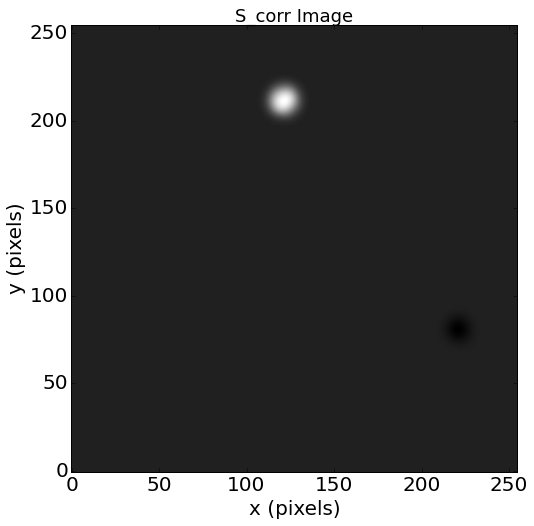

In [56]:
fig = plt.figure(figsize = (8,8))
plt.imshow(S_corr, cmap = 'gray', origin='lower')
plt.title('S_corr Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [57]:
plt.close(fig)

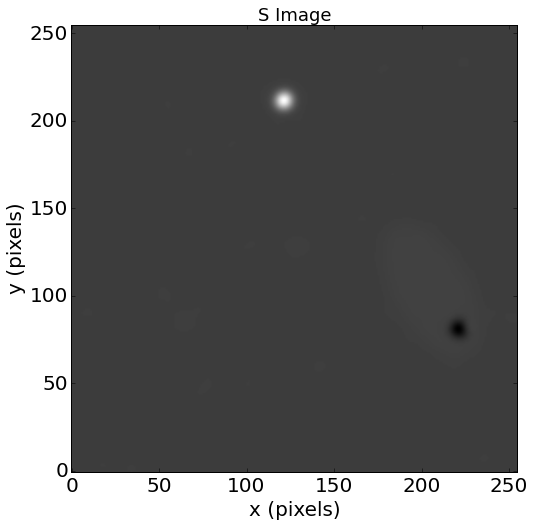

In [58]:
fig = plt.figure(figsize = (8,8))
plt.imshow(S, cmap = 'gray', origin='lower')
plt.title('S Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [59]:
plt.close(fig)

Candidate 1: (126.6144945, 127.027607836)


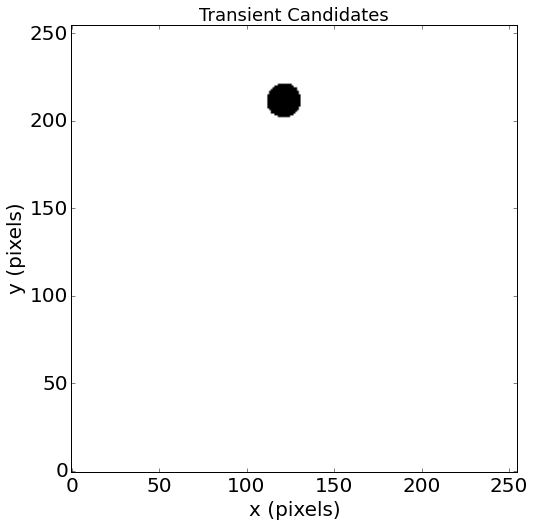

In [60]:
print_candidates(S_corr, 5)

In [61]:
plt.close(fig)

Candidate (minimum analysis) 1: (127.027607836, 126.6144945)


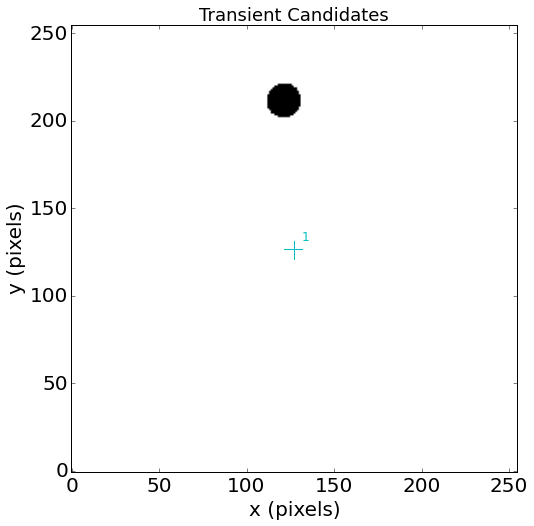

In [62]:
print_candidates_min(S_corr,5)

In [63]:
plt.close(fig)

Candidate (maximum analysis) 1: (120.973799127, 210.951965066)


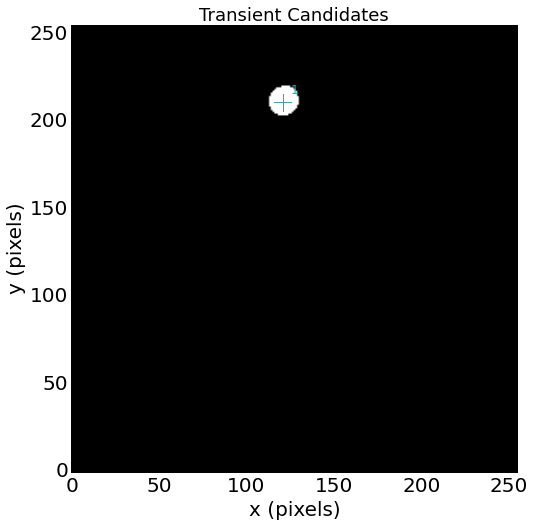

In [64]:
print_candidates_max(S_corr,8)

In [65]:
plt.close(fig)

Candidate (maximum analysis) 1: (220.5, 81.0)
Candidate (maximum analysis) 2: (121.0, 211.0)


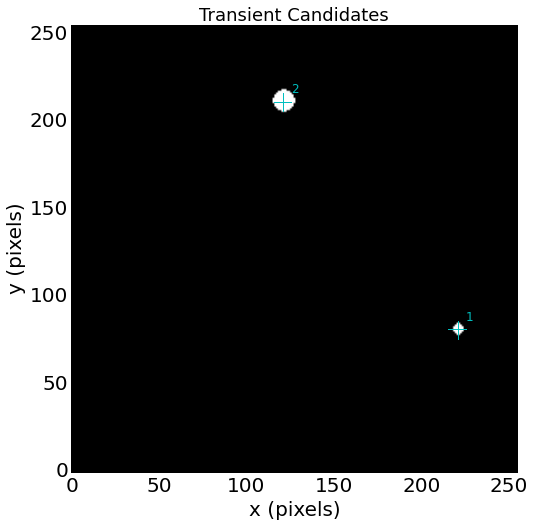

In [66]:
print_candidates_max(S,8)

In [67]:
plt.close(fig)

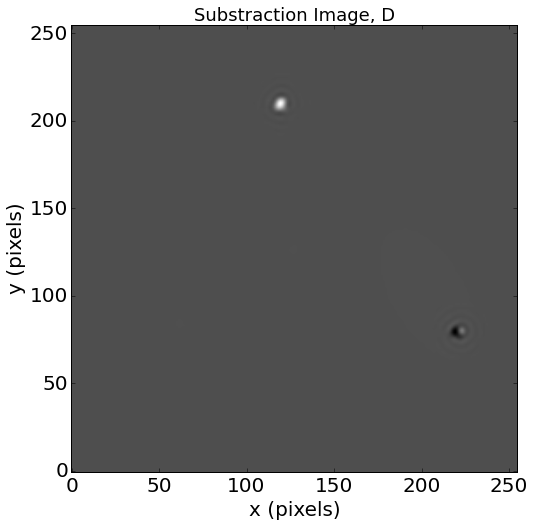

In [68]:
fig = plt.figure(figsize = (8,8))
plt.imshow(D, cmap = 'gray', origin='lower')
plt.title('Substraction Image, D', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [69]:
plt.close(fig)

Tests with real images and point transients

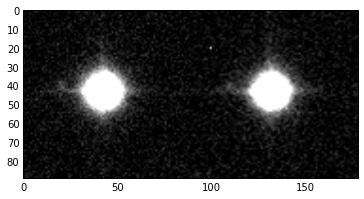

In [70]:
R = fits.getdata('./Fits/science.fits')
N = fits.getdata('./Fits/template_points.fits')
vis = np.concatenate((R, N), axis=1)
plt.imshow(Image.fromarray(vis), cmap = 'gray')

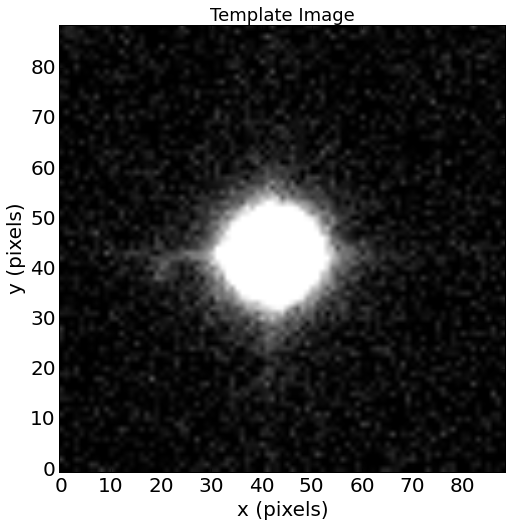

In [71]:
fig = plt.figure(figsize = (8,8))
plt.imshow(Image.fromarray(R), cmap = 'gray', origin='lower')
plt.title('Template Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [72]:
plt.close(fig)

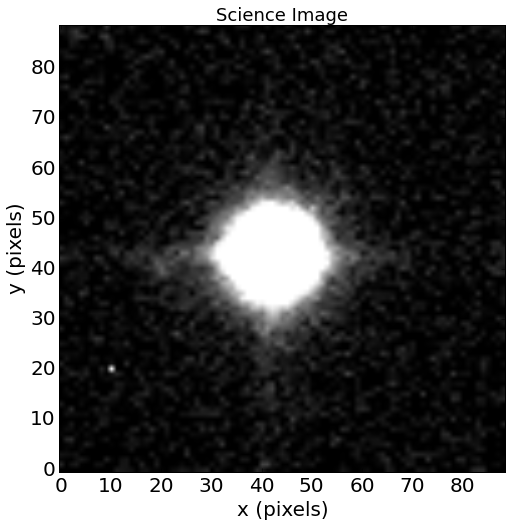

In [73]:
fig = plt.figure(figsize = (8,8))
plt.imshow(Image.fromarray(N), cmap = 'gray', origin='lower')
plt.title('Science Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [74]:
plt.close(fig)

In [75]:
# The mask has 0s for the background and 1s for the source
mask = asarray(pickle.load(open("./Fits/mask.p", "rb" )))

In [76]:
# Estimating noise parameters
R_background_pixels = []
N_background_pixels = []
for i in range(len(mask)):
    for j in range(len(mask)):
        # We exclude the new source in the background
        if mask[i, j] == 0 and (i != 20 or j != 10):
            R_background_pixels.append(R[i, j])
            N_background_pixels.append(N[i, j])
sigma_r = std(R_background_pixels) 
sigma_n = std(N_background_pixels)

(mu_r, sigma_r) = norm.fit(R_background_pixels)
(mu_n, sigma_n) = norm.fit(N_background_pixels)
print("sigma_r: " + str(sigma_r))
print("sigma_n: " + str(sigma_n))

sigma_r: 19.9943
sigma_n: 17.737


In [77]:
# Estimating PSFs.
(mu_PSF_r, sigma_PSF_r) = norm.fit(np.concatenate([-1*R.ravel(), R.ravel()]))
(mu_PSF_n, sigma_PSF_n) = norm.fit(np.concatenate([-1*N.ravel(), N.ravel()]))
# Because the PSFs have such large sigmas, the tile size greatly affects sensitivity
tile_size = 3

PSF_r = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF_r), R)
PSF_n = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF_n), N)
print("sigma_PSF_r: " + str(sigma_PSF_r))
print("sigma_PSF_n: " + str(sigma_PSF_n))

sigma_PSF_r: 1738.95
sigma_PSF_n: 1879.76


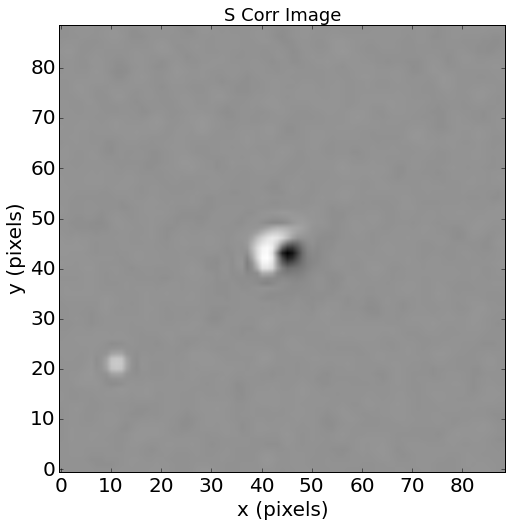

In [78]:
# Calculating S
# This has to be remade
r_n = sigma_n
r_r = sigma_r

N_b = N
R_b = R

S_corr = get_S_corr_source(sigma_r, sigma_n, PSF_r, PSF_n, R, N, N_b, R_b, r_n, r_r)

fig = plt.figure(figsize = (8,8))
plt.imshow(S_corr, cmap = 'Greys_r', origin='lower')
plt.title('S Corr Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [79]:
plt.close(fig)

Candidate 1: (44.0773381295, 44.0967368962)
Candidate 2: (41.5, 43.0)


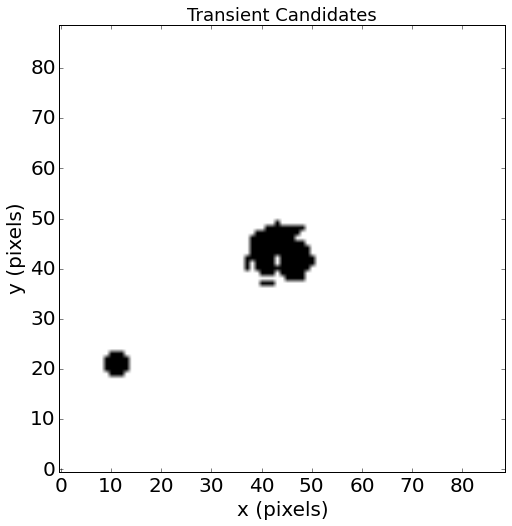

In [80]:
# We pick the highest threshold (up to two decimal places) with which both transients are detected.
print_candidates(S_corr, 1.3)

In [81]:
plt.close(fig)

Candidate (minimum analysis) 1: (44.0990886921, 44.074829932)
Candidate (minimum analysis) 2: (43.0, 41.5)


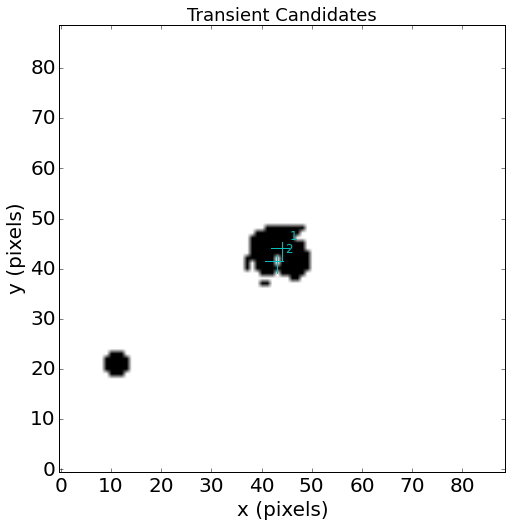

In [82]:
print_candidates_min(S_corr, 1.4)

In [83]:
plt.close(fig)

Candidate (maximum analysis) 1: (11.0, 21.0)
Candidate (maximum analysis) 2: (41.0, 37.0)
Candidate (maximum analysis) 3: (43.5585585586, 43.1621621622)


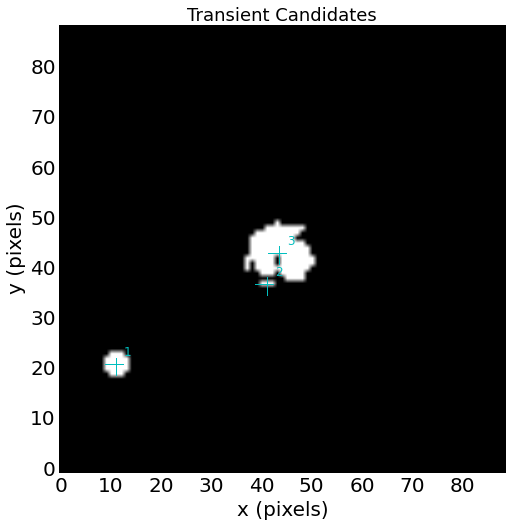

In [84]:
print_candidates_max(S_corr, 1.3)

In [85]:
plt.close(fig)

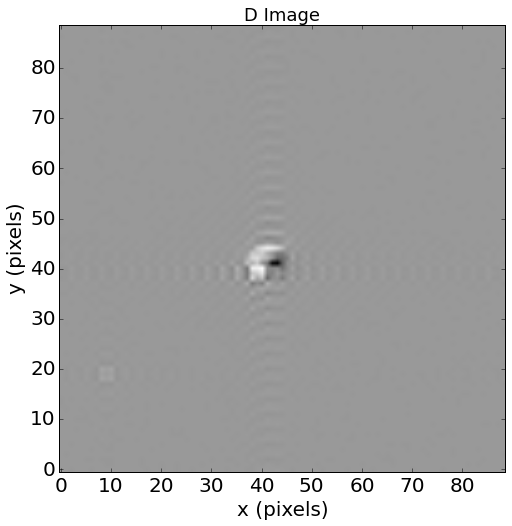

In [86]:
# Calculating D
D = get_D(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
fig = plt.figure(figsize = (8,8))
plt.imshow(D, cmap = 'Greys_r', origin='lower')
plt.title('D Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [87]:
plt.close(fig)

Tests with real images and gaussian transients

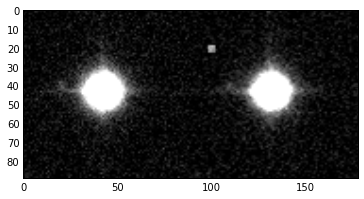

In [88]:
R = fits.getdata('./Fits/science.fits')
N = fits.getdata('./Fits/template_gaussians.fits')
vis = np.concatenate((R, N), axis=1)
plt.imshow(Image.fromarray(vis), cmap = 'gray')
mask = asarray(pickle.load(open("./Fits/mask.p", "rb" )))

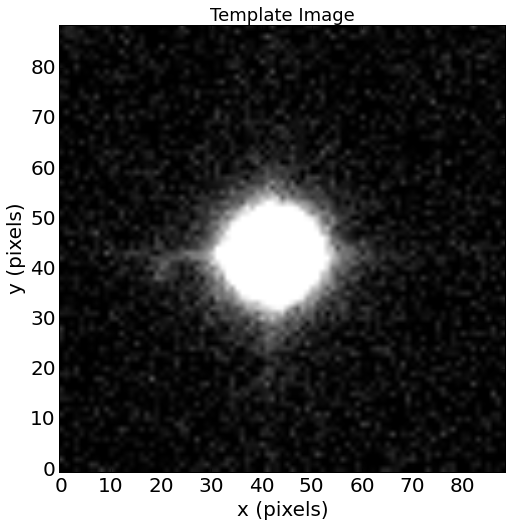

In [89]:
fig = plt.figure(figsize = (8,8))
plt.imshow(Image.fromarray(R), cmap = 'gray', origin='lower')
plt.title('Template Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [90]:
plt.close(fig)

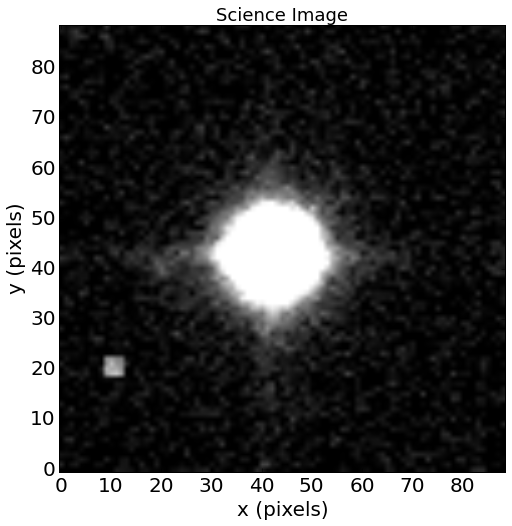

In [91]:
fig = plt.figure(figsize = (8,8))
plt.imshow(Image.fromarray(N), cmap = 'gray', origin='lower')
plt.title('Science Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [92]:
plt.close(fig)

In [93]:
# Estimating noise parameters
R_background_pixels = []
N_background_pixels = []
for i in range(len(mask)):
    for j in range(len(mask)):
        # We exclude the new source in the background
        if mask[i, j] == 0 and ((i < 19 or i > 21) or (j < 9 or j > 11)):
            R_background_pixels.append(R[i, j])
            N_background_pixels.append(N[i, j])
sigma_r = std(R_background_pixels) 
sigma_n = std(N_background_pixels)

(mu_r, sigma_r) = norm.fit(R_background_pixels)
(mu_n, sigma_n) = norm.fit(N_background_pixels)
print("sigma_r: " + str(sigma_r))
print("sigma_n: " + str(sigma_n))

sigma_r: 19.9963
sigma_n: 18.3795


In [94]:
# Estimating PSFs.
(mu_PSF_r, sigma_PSF_r) = norm.fit(np.concatenate([-1*R.ravel(), R.ravel()]))
(mu_PSF_n, sigma_PSF_n) = norm.fit(np.concatenate([-1*N.ravel(), N.ravel()]))
# Because the PSFs have such large sigmas, the tile size greatly affects sensitivity
tile_size = 3

PSF_r = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF_r), R)
PSF_n = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF_n), N)
print("sigma_PSF_r: " + str(sigma_PSF_r))
print("sigma_PSF_n: " + str(sigma_PSF_n))

sigma_PSF_r: 1738.95
sigma_PSF_n: 1848.02


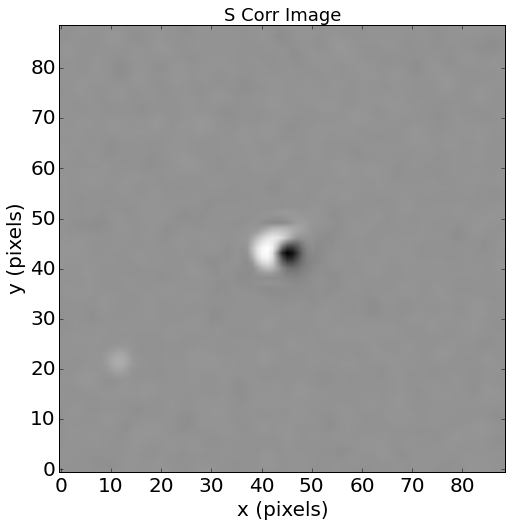

In [95]:
# Calculating S
# This has to be remade
r_n = sigma_n
r_r = sigma_r

N_b = N
R_b = R

S_corr = get_S_corr_source(sigma_r, sigma_n, PSF_r, PSF_n, R, N, N_b, R_b, r_n, r_r)

fig = plt.figure(figsize = (8,8))
plt.imshow(S_corr, cmap = 'Greys_r', origin='lower')
plt.title('S Corr Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [96]:
plt.close(fig)

Candidate 1: (44.0511276269, 44.0658636597)
Candidate 2: (42.0, 43.0)


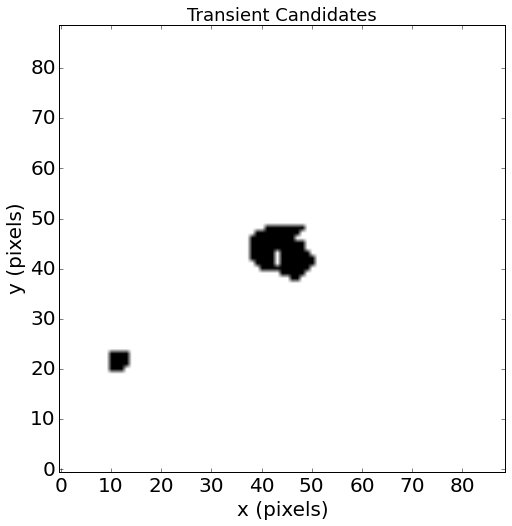

In [97]:
# We pick the highest threshold (up to two decimal places) with which both transients are detected.
print_candidates(S_corr, 1.51)

In [98]:
plt.close(fig)

Candidate (minimum analysis) 1: (44.0658636597, 44.0511276269)
Candidate (minimum analysis) 2: (43.0, 42.0)


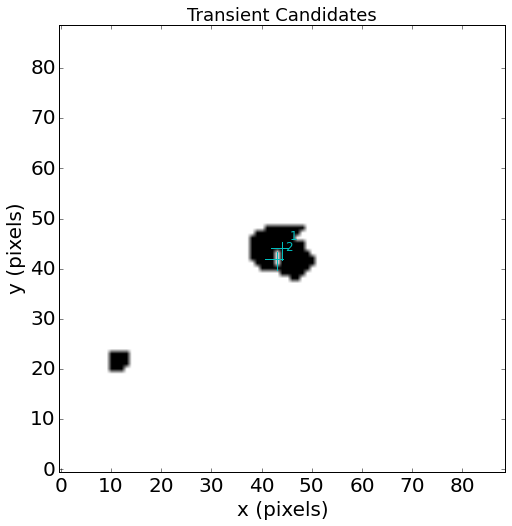

In [99]:
print_candidates_min(S_corr, 1.51)

In [100]:
plt.close(fig)

Candidate (maximum analysis) 1: (11.4, 21.6)
Candidate (maximum analysis) 2: (43.73, 43.39)


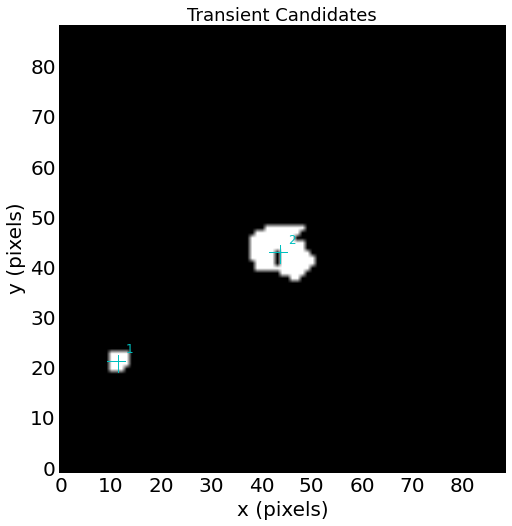

In [101]:
print_candidates_max(S_corr, 1.50)

In [102]:
plt.close(fig)

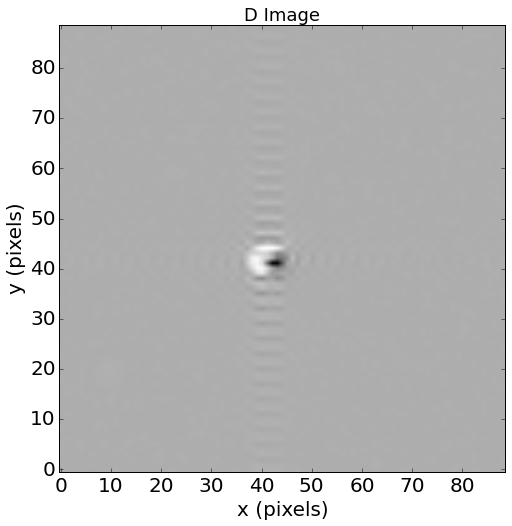

In [103]:
# Calculating D
D = get_D(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
fig = plt.figure(figsize = (8,8))
plt.imshow(D, cmap = 'Greys_r', origin='lower')
plt.title('D Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [104]:
plt.close(fig)

Tests with real images and transients

In [105]:
R = fits.getdata('./Fits/Real/S-1/33,15.fits')
N = fits.getdata('./Fits/Real/S+0/33,15.fits')
# This pipeline requires the dimensions of the images to be odd.
R = R[:-1,:-1]
N = N[:-1,:-1]

In [106]:
# Estimating noise parameters
# Because we have no mask to differentiate background and sources in this case, we take noise 
# as the 10% least intense pixels of the images
R_background_pixels = sort(R)[0:int(0.1*len(R))]
N_background_pixels = sort(N)[0:int(0.1*len(N))]
sigma_r = std(R_background_pixels) 
sigma_n = std(N_background_pixels)

(mu_r, sigma_r) = norm.fit(R_background_pixels)
(mu_n, sigma_n) = norm.fit(N_background_pixels)
print("sigma_r: " + str(sigma_r))
print("sigma_n: " + str(sigma_n))

sigma_r: 3.43099
sigma_n: 4.04183


In [107]:
# Estimating PSFs.
(mu_PSF_r, sigma_PSF_r) = norm.fit(np.concatenate([-1*R.ravel(), R.ravel()]))
(mu_PSF_n, sigma_PSF_n) = norm.fit(np.concatenate([-1*N.ravel(), N.ravel()]))
tile_size = 5

PSF_r = get_correct_PSF_representation(get_convolution_matrix(tile_size - 1, sigma_PSF_r), R)
PSF_n = get_correct_PSF_representation(get_convolution_matrix(tile_size - 1, sigma_PSF_n), N)
print("sigma_PSF_r: " + str(sigma_PSF_r))
print("sigma_PSF_n: " + str(sigma_PSF_n))

sigma_PSF_r: 7.02189
sigma_PSF_n: 10.1536


In [108]:
# Calculating S
# For testing
r_n = sigma_n
r_r = sigma_r

N_b = N
R_b = R

S =  get_S_simple(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
S_corr = get_S_corr_source(sigma_r, sigma_n, PSF_r, PSF_n, R, N, N_b, R_b, r_n, r_r)


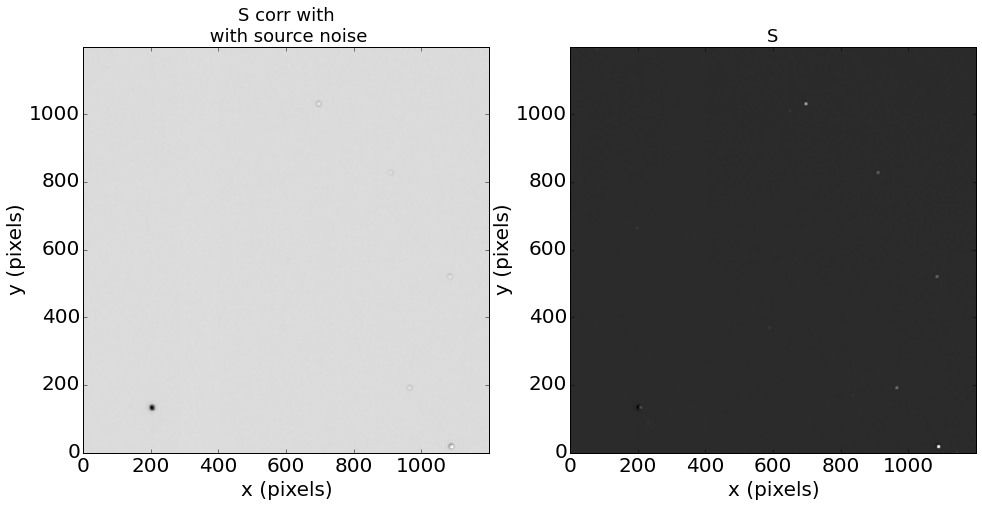

In [109]:
fig = plt.figure(figsize = (16,8))
fig.add_subplot(1, 2, 1)  # this line outputs images side-by-side
plt.imshow(S_corr, cmap = 'gray', origin='lower')
plt.title('S corr with  \n with source noise', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
fig.add_subplot(1, 2, 2)  # this line outputs images side-by-side
plt.imshow(S,  cmap = 'gray', origin='lower')
plt.title('S', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [110]:
plt.close(fig)

Candidate 1: (21.78125, 1081.5625)
Candidate 2: (133.0, 203.987951807)
Candidate 3: (1035.0, 694.0)


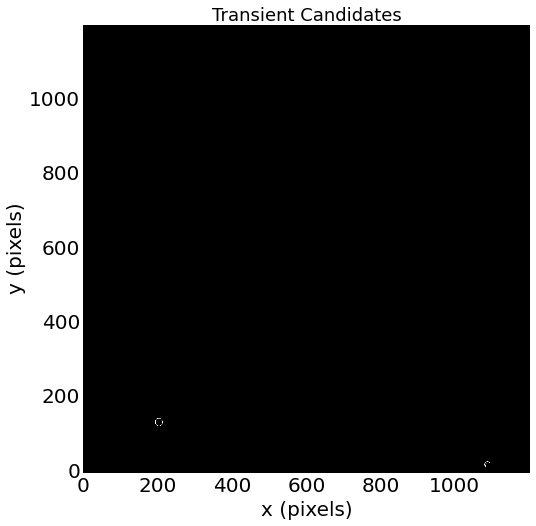

In [111]:
print_candidates(S_corr, 5)

In [112]:
plt.close(fig)

Candidate (maximum analysis) 1: (599.001980447, 599.01657816)


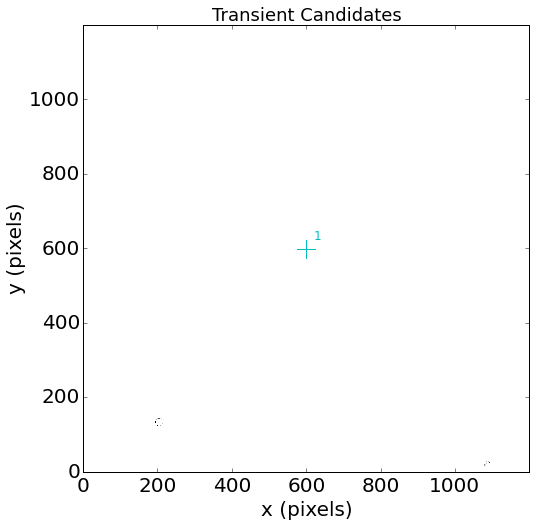

In [113]:
print_candidates_max(S_corr,2)

In [114]:
plt.close(fig)

Candidate (minimum analysis) 1: (1081.44303797, 21.7974683544)
Candidate (minimum analysis) 2: (204.362637363, 132.846153846)
Candidate (minimum analysis) 3: (694.0, 1035.0)


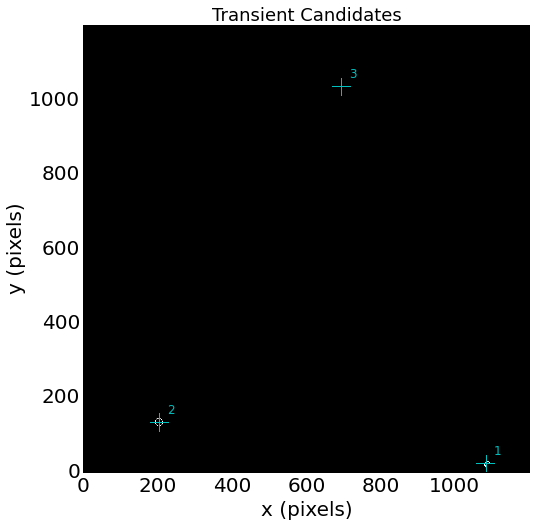

In [115]:
print_candidates_min(S_corr,6)

In [116]:
plt.close(fig)

In [117]:
# Calculating D
D = get_D(sigma_r, sigma_n, PSF_r, PSF_n, R, N)

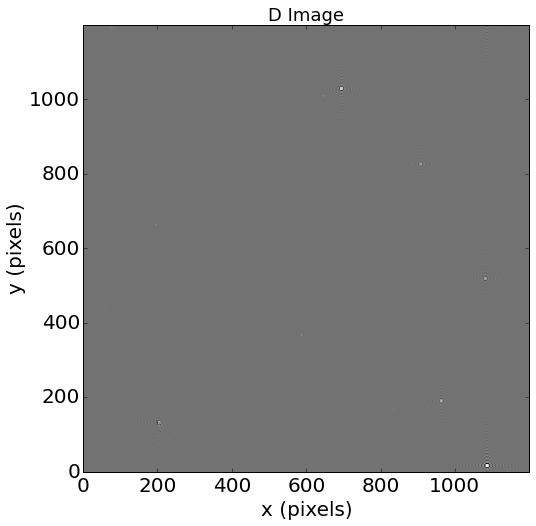

In [118]:
fig = plt.figure(figsize = (8,8))
plt.imshow(D, cmap = 'Greys_r', origin='lower')
plt.title('D Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [119]:
plt.close(fig)

For other real images

In [120]:
R = fits.getdata('./Fits/Real/S+0/33,15.fits')
N = fits.getdata('./Fits/Real/S+1/33,15.fits')
# This pipeline requires the dimensions of the images to be odd.
R = R[:-1,:-1]
N = N[:-1,:-1]

In [121]:
# Estimating noise parameters
R_background_pixels = sort(R)[0:int(0.1*len(R))]
N_background_pixels = sort(N)[0:int(0.1*len(R))]
sigma_r = std(R_background_pixels) 
sigma_n = std(N_background_pixels)

(mu_r, sigma_r) = norm.fit(R_background_pixels)
(mu_n, sigma_n) = norm.fit(N_background_pixels)
print("sigma_r: " + str(sigma_r))
print("sigma_n: " + str(sigma_n))

sigma_r: 4.04183
sigma_n: 3.47929


In [122]:
# Estimating PSFs.
(mu_PSF_r, sigma_PSF_r) = norm.fit(np.concatenate([-1*R.ravel(), R.ravel()]))
(mu_PSF_n, sigma_PSF_n) = norm.fit(np.concatenate([-1*N.ravel(), N.ravel()]))
tile_size = 5

PSF_r = get_correct_PSF_representation(get_convolution_matrix(tile_size - 1, sigma_PSF_r), R)
PSF_n = get_correct_PSF_representation(get_convolution_matrix(tile_size - 1, sigma_PSF_n), N)
print("sigma_PSF_r: " + str(sigma_PSF_r))
print("sigma_PSF_n: " + str(sigma_PSF_n))

sigma_PSF_r: 10.1536
sigma_PSF_n: 16.2016


In [123]:
# Calculating S
S =  get_S_simple(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
S_corr = get_S_corr_source(sigma_r, sigma_n, PSF_r, PSF_n, R, N, N_b, R_b, r_n, r_r)

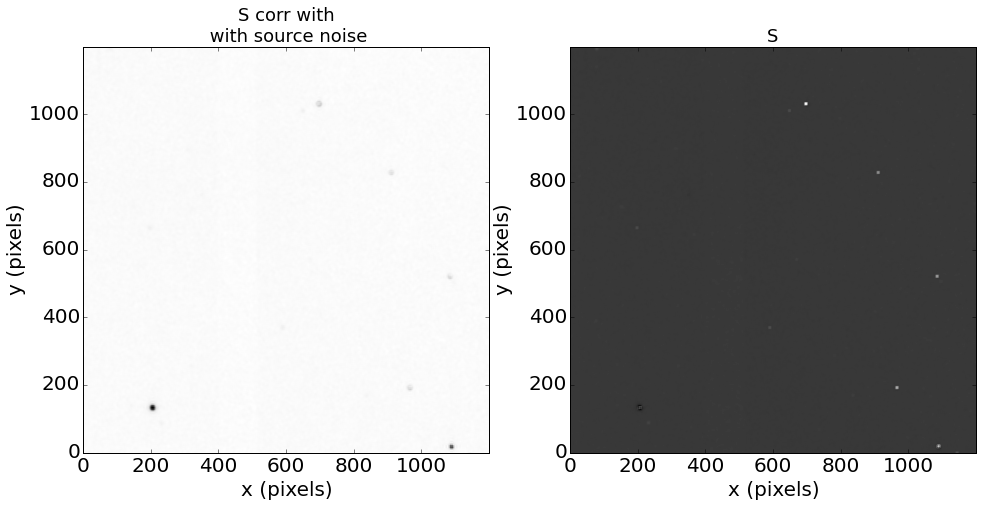

In [124]:
fig = plt.figure(figsize = (16,8))
fig.add_subplot(1, 2, 1)  # this line outputs images side-by-side
plt.imshow(S_corr, cmap = 'gray', origin='lower')
plt.title('S corr with  \n with source noise', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
fig.add_subplot(1, 2, 2)  # this line outputs images side-by-side
plt.imshow(S,  cmap = 'gray', origin='lower')
plt.title('S', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [125]:
plt.close(fig)

Candidate 1: (11.5882352941, 1086.29411765)
Candidate 2: (15.0, 1089.0)
Candidate 3: (127.487804878, 207.56097561)
Candidate 4: (138.702970297, 202.544554455)
Candidate 5: (131.25, 208.0)


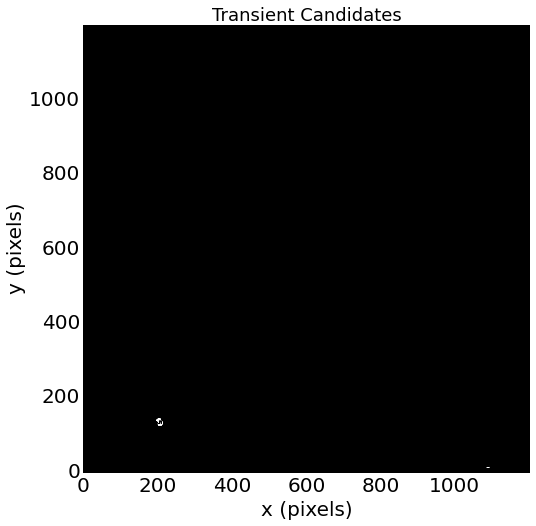

In [126]:
print_candidates(S, 50)

In [127]:
plt.close(fig)

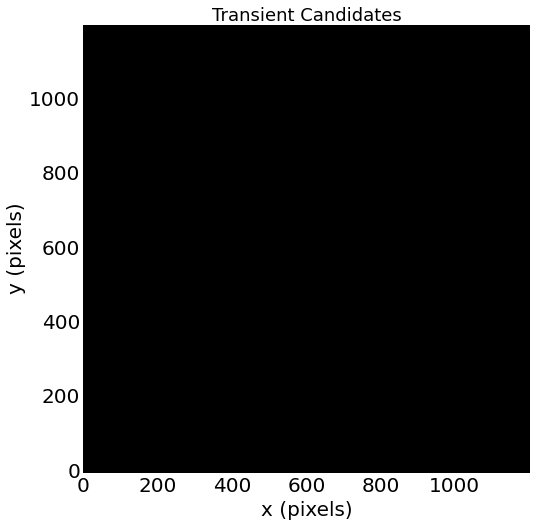

In [139]:
print_candidates_max(S_corr,50)

In [129]:
plt.close(fig)

Candidate (minimum analysis) 1: (1085.88888889, 18.7037037037)
Candidate (minimum analysis) 2: (1081.5, 14.5)
Candidate (minimum analysis) 3: (208.72, 130.92)
Candidate (minimum analysis) 4: (198.5, 128.5)
Candidate (minimum analysis) 5: (200.0625, 137.9375)


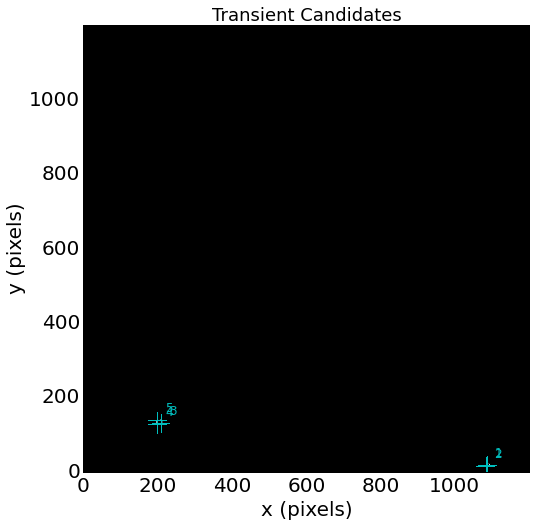

In [136]:
print_candidates_min(S_corr,5)

In [131]:
plt.close(fig)

In [132]:
# Calculating D
D = get_D(sigma_r, sigma_n, PSF_r, PSF_n, R, N)

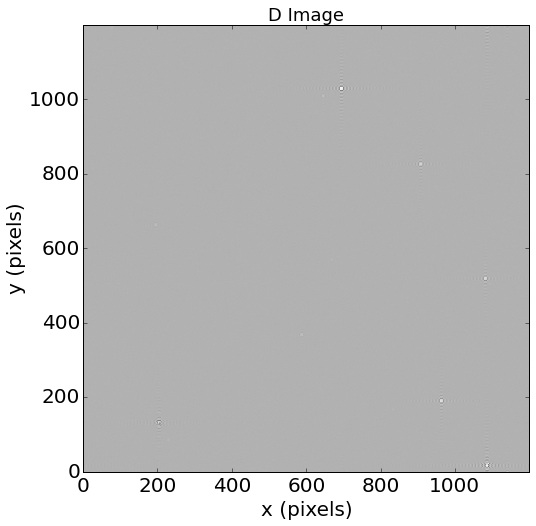

In [133]:
fig = plt.figure(figsize = (8,8))
plt.imshow(D, cmap = 'Greys_r', origin='lower')
plt.title('D Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [134]:
plt.close(fig)